<a href="https://colab.research.google.com/github/xxziris/cancer_image_classification/blob/main/Cancer_histology_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BS6207 Assignment 4

Given histology images: 
1. Artifacts
2. Cancer Regions
3. Normal Regions
4. Others

Build a CNN to perform 4-class classification. Do not download CNN online, construct your own.

Perform tuning of parameters such as learning rate, rate decay, dropout, network architecture adjustment, weight decay, early stopping and use many other tricks.

Images are ordered by index for each class. Take the first 100 images from each class as your test set. Use the rest for training and validations.

You are not allowed to touch these first 100 images in all your network design and tuning.

Generate a plot of test accuracy versus total number of images used in your training set. Start from a total of 40 training images to the maximum that you can use.

Try to achieve as high test accuracy as possible with as few training images as possible.

In [ ]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import os
import shutil
import glob
import random
from imgaug import augmenters as iaa
import imageio
import imgaug as ia

## 1. Sort and label the images

The images were provided in 4 separate folders based on the class label. To prepare the images for neural network, the following steps are taken:
1. Modify the image name to include class labels. For example, all images in `artifacts` folder were renamed as `artifactsXXX.png`, where XXX is running number.
2. Take the first 100 images from each class as the test set. Copy and paste these 400 images together into a separate folder (`test_data`)
3. Put the rest of the images into a separate folder by class (e.g. `artifacts_train_val`), which contains the images to be used for both training and validation later)
4. Check the number of images in each class folder for training and validation:
  * artifacts: 2280
  * cancer_region: 2778
  * normal_region: 1087
  * others: 384

5. There is class imbalance problem that `others` class is particularly small. Hence, image augmentation is applied to `normal_region` and `others` class to generate more images.
  * For each `normal_region` image, 1 augmented image is generated. For each `others` class image, 6 augmented images are generated.
  * The augmented image may be generated by flipping, cropping, scaling and rotating the original image:
    * Fliplr = 0.5 -> 50% of the images will be flipped horizontally
    * Crop(percent = (0,0.1)) -> crop some of the images by 0-10% of their height/width
    * Affine(scale = {'x': (0.9,1.3), 'y': (0.9,1.3)}, rotate=(-25,25)) -> scale to 90% -130% of image height or width; rotate by -25 to +25 degree
6. Check the number of images per class after augmentation:
  * artifacts: 2280
  * cancer_region: 2778
  * normal_region: 2174
  * others: 2688

The classes are roughly balanced.

In [ ]:
# rename images in each folder with class label - artifacts
os.chdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/artifacts')
i = 1
for file in os.listdir():
  src = file
  dst = 'artifacts'+str(i)+'.png'
  os.rename(src, dst)
  i += 1

In [ ]:
# rename images in each folder with class label - cancer_regions
os.chdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/cancer_regions')
i = 1
for file in os.listdir():
  src = file
  dst = 'cancer'+str(i)+'.png'
  os.rename(src, dst)
  i += 1

# rename images in each folder with class label - normal_regions
os.chdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/normal_regions')
i = 1
for file in os.listdir():
  src = file
  dst = 'normal'+str(i)+'.png'
  os.rename(src, dst)
  i += 1

# rename images in each folder with class label - others
os.chdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/other')
i = 1
for file in os.listdir():
  src = file
  dst = 'other'+str(i)+'.png'
  os.rename(src, dst)
  i += 1

In [ ]:
# retrieve file names in folder
artifact_file = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/artifacts/*')
cancer_file = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/cancer_regions/*')
normal_file = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/normal_regions/*')
other_file = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/other/*')

In [ ]:
# get the number of images per class
print('artifacts: ', len(artifact_file))
print('cancer_regions: ', len(cancer_file))
print('normal_regions: ', len(normal_file))
print('others: ', len(other_file))

artifacts:  2380
cancer_regions:  2878
normal_regions:  1187
others:  484


In [ ]:
# separate the first 100 images per class as test set
artifact_test = artifact_file[:100]
cancer_test = cancer_file[:100]
normal_test = normal_file[:100]
other_test = other_file[:100]
test_files = np.concatenate([artifact_test, cancer_test, normal_test, other_test])

In [ ]:
# remove the test images from the pool, so that they are not used for train and validation
artifact_file = list(set(artifact_file) - set(artifact_test))
cancer_file = list(set(cancer_file) - set(cancer_test))
normal_file = list(set(normal_file) - set(normal_test))
other_file = list(set(other_file) - set(other_test))

In [ ]:
# store the test images into separate folder
test_dir = '/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/test_data' # specify directory
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None # make directory

for fn in test_files: # sort the files
  shutil.copy(fn, test_dir)

In [ ]:
test_files = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/test_data/*')

In [ ]:
# move the rest of the images to a new foler for train-val split
os.mkdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/other_train_val') if not os.path.isdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/other_train_val') else None
os.mkdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/normal_train_val') if not os.path.isdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/normal_train_val') else None
os.mkdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/cancer_train_val') if not os.path.isdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/cancer_train_val') else None
os.mkdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/artifact_train_val') if not os.path.isdir('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/artifact_train_val') else None

for fn in other_file: 
  shutil.copy(fn, '/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/other_train_val')

for fn in normal_file: 
  shutil.copy(fn, '/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/normal_train_val')

for fn in cancer_file: 
  shutil.copy(fn, '/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/cancer_train_val')

for fn in artifact_file: 
  shutil.copy(fn, '/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/artifact_train_val')

In [ ]:
# update file list 
artifact_file = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/artifact_train_val/*')
cancer_file = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/cancer_train_val/*')
normal_file = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/normal_train_val/*')
other_file = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/other_train_val/*')

In [ ]:
# get the number of images per class
print('artifacts: ', len(artifact_file))
print('cancer_regions: ', len(cancer_file))
print('normal_regions: ', len(normal_file))
print('others: ', len(other_file))

artifacts:  2280
cancer_regions:  2778
normal_regions:  1087
others:  384


Due to the imbalanced class of `normal_regions` and `other`, image augmentation is applied selectively to these 2 classes to generate more images to balance the class.

In [ ]:
# loop through each `other` image and create 6 additional augmented images
random.seed(127)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Affine(scale = {'x': (0.9,1.3), 'y': (0.9,1.3)},
               rotate=(-25,25))
], random_order=True)


for fname in other_file:
    img = imageio.imread(fname)
    # print(fname)
    # print('Original:')
    # ia.imshow(img)
    for num in range(6):
      img_aug = seq.augment_image(img)
      # print('Augmented:')
      # ia.imshow(img_aug)
      # print(os.path.join(fname[:-4] + "_%i_aug.png" % (num,)))
      imageio.imwrite(os.path.join(fname[:-4] + "_%i_aug.png" % (num,)), img_aug)

In [ ]:
# loop through each `normal_region` image and create 1 additional augmented images
random.seed(127)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Affine(scale = {'x': (0.9,1.3), 'y': (0.9,1.3)},
               rotate=(-25,25))
], random_order=True)


for fname in normal_file:
    img = imageio.imread(fname)
    # print(fname)
    # print('Original:')
    # ia.imshow(img)
    img_aug = seq.augment_image(img)
    # print('Augmented:')
    # ia.imshow(img_aug)
    # print(os.path.join(fname[:-4] + "_%i_aug.png" % (num,)))
    imageio.imwrite(os.path.join(fname[:-4] + "_aug.png" ), img_aug)

In [ ]:
normal_file = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/normal_train_val/*')
other_file = glob.glob('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment4/other_train_val/*')
# get the number of images per class after augmentation
print('artifacts: ', len(artifact_file))
print('cancer_regions: ', len(cancer_file))
print('normal_regions: ', len(normal_file))
print('others: ', len(other_file))

artifacts:  2280
cancer_regions:  2778
normal_regions:  2174
others:  2688


## 2. Build a CNN network and fine-tune the parameters

To build the CNN network, the following steps are taken:
1. From each train_validation folder, randomly select 70% of the images as training, and the rest will be used for validation.
2. Based on the image file names, generate the training/validation label list, which contains string labels (e.g. `normal`, `cancer`, etc.)
3. Read the images based on the train/validation filename list, and then convert the images into arrays. Each image is converted to a (1,128,128) array, where the images were imported as gray scale (i.e. one channel only).
4. The arrays are then normalized by dividing all pixel values by 255.
5. Convert the label list from string to numerical levels (i.e. 0~3) using sklearn.LabelEncoder.
6. Define the training and validation dataloader, where the trainloader has a batch size of 50, and valloader has a batch size of 1.
7. Build the test dataloader using the same approach.
8. Build the CNN model:
  * The CNN model contains 3 CNN layers. After each CNN layers, the output is processed by: 
    * `ReLU` - to introduce non-linearity in the image
    * `batch normalization` - standardize the inputs to a layer for each mini-batch
    * `Maxpooling2D` - generates pooled features maps that highlight the most present features from the image
  * After the 3 CNN layers, 2 densely connected layers are introduced with dropout and ReLU.
  * The output of the CNN model is raw score, for the convenience of using `CrossEntropy` as the loss function
9. Techniques used to fine-tune the CNN models include:
 * `Dropout` - 50% of the nodes are dropped out randomly to prevent overfitting
 * `Adam gradient descent` is employed to find the minima, which is better than stochastic gradient descent and is less likely to stuck at local minima
 * `Weight decay` of 0.005 is used in order to prevent overfitting. It keeps the weights small and avoids exploding gradients.
 * `Model architecture`: the model is adjusted so that there are not too many parameters to train. As the training size is rather limited, a relatively simple model might have better performance than complicated ones. There are in total 9016 parameters in the final model.
 * `Early Stopping` is used to stop training if the validation loss does not drop anymore. This is also to prevent overfitting issues. 
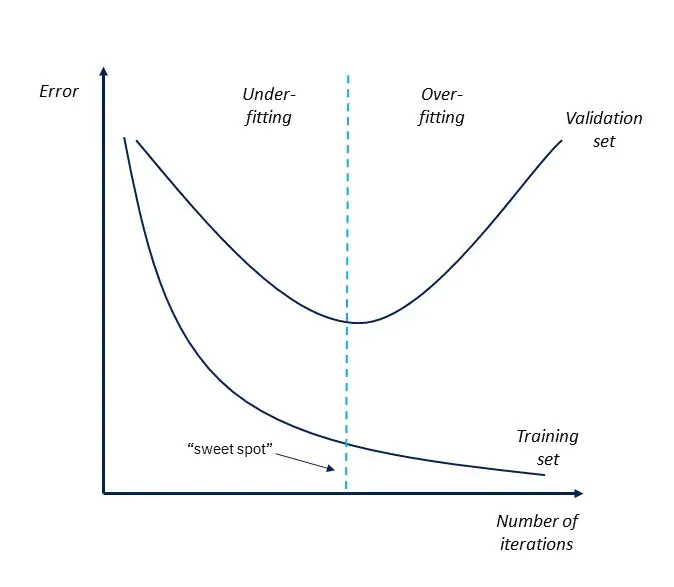

In [ ]:
# randomly select 70% from each class to form training set
random.seed(127)
artifact_train = np.random.choice(artifact_file, size= int(0.7*len(artifact_file)), replace = False)
cancer_train = np.random.choice(cancer_file, size= int(0.7*len(cancer_file)), replace = False)
normal_train = np.random.choice(normal_file, size= int(0.7*len(normal_file)), replace = False)
other_train = np.random.choice(other_file, size= int(0.7*len(other_file)), replace = False)

# the remaining images are for validation
artifact_val = list(set(artifact_file) - set(artifact_train))
cancer_val = list(set(cancer_file) - set(cancer_train))
normal_val = list(set(normal_file) - set(normal_train))
other_val = list(set(other_file) - set(other_train))

# concatenate all train/validation together
train_file = np.concatenate([artifact_train, cancer_train, normal_train, other_train])
val_file = np.concatenate([artifact_val, cancer_val, normal_val, other_val])

# randomly shuffle the sequence of train_file and val_file
np.random.shuffle(train_file)
np.random.shuffle(val_file)

In [ ]:
# generate the train_label and val_label
train_labels = []
for fn in train_file:
  if 'other' in fn:
    train_labels.append('other')
  elif 'cancer' in fn:
    train_labels.append('cancer')
  elif 'normal' in fn:
    train_labels.append('normal')
  elif 'artifacts' in fn:
    train_labels.append('artifact')

val_labels = []
for fn in val_file:
  if 'other' in fn:
    val_labels.append('other')
  elif 'cancer' in fn:
    val_labels.append('cancer')
  elif 'normal' in fn:
    val_labels.append('normal')
  elif 'artifacts' in fn:
    val_labels.append('artifact')

In [ ]:
# load the training images
train_img = []
for fn in train_file:
  img = imageio.imread(fn, as_gray = True) # load gray-scale image as array
  img /= 255.0 # normalize the pixel value
  img = img.astype('float32') # conver the value type to float32
  train_img.append(img) # append to list

# load the validation images
val_img = []
for fn in val_file:
  img = imageio.imread(fn, as_gray = True) # load gray-scale image as array
  img /= 255.0 # normalize the pixel value
  img = img.astype('float32') # conver the value type to float32
  val_img.append(img) # append to list

In [ ]:
# convert the list to torch.tensor
train_x = np.array(train_img)
train_x = train_x.reshape(6942,1,128,128)
#train_x = torch.from_numpy(train_x)

val_x = np.array(val_img)
val_x = val_x.reshape(2978,1,128,128)
#val_x = torch.from_numpy(val_x)

In [ ]:
# convert labels to 1/2/3/4 and convert them to torch.tensor
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

#train_y = torch.from_numpy(train_labels_enc)
#val_y = torch.from_numpy(val_labels_enc)

In [ ]:
# defining trainloader and valloader
train_data = []
for i in range(len(train_x)):
  train_data.append([train_x[i], train_labels_enc[i]])

trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 50)

val_data = []
for i in range(len(val_x)):
  val_data.append([val_x[i], val_labels_enc[i]])

valloader = torch.utils.data.DataLoader(val_data, shuffle = True, batch_size = 1)

In [ ]:
# build the test image dataloader
test_img = []
for fn in test_files:
  img = imageio.imread(fn, as_gray = True) # load gray-scale image as array
  img /= 255.0 # normalize the pixel value
  img = img.astype('float32') # conver the value type to float32
  test_img.append(img) # append to list

test_x = np.array(test_img)
test_x = test_x.reshape(test_x.shape[0],1,128,128)

# generate ground truth label of test images
test_labels = []
for fn in test_files:
  if 'other' in fn:
    test_labels.append('other')
  elif 'cancer' in fn:
    test_labels.append('cancer')
  elif 'normal' in fn:
    test_labels.append('normal')
  elif 'artifacts' in fn:
    test_labels.append('artifact')
test_labels_enc = le.transform(test_labels)

test_data = []
for i in range(len(test_x)):
  test_data.append([test_x[i], test_labels_enc[i]])

testloader = torch.utils.data.DataLoader(test_data, shuffle = True)

In [ ]:
# define the CNN
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.cnn_layers = nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=6, stride=1, padding=0),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=4, stride=2),
        # Defining another 2D convolution layer
        nn.Conv2d(4, 8, kernel_size=6, stride=2, padding=0),
        nn.BatchNorm2d(8),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=4, stride=2),
        # Defining another 2D convolution layer
        nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        )
    self.linear_layers = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(16 * 5 * 5 , 16),
            nn.ReLU(),
            nn.Linear(16,4)
        )

  def forward(self, x):
    x = self.cnn_layers(x)
    #x = torch.flatten(x)
    x = torch.flatten(x, start_dim = 1)
    x = self.linear_layers(x)
    return x

In [ ]:
model = Net()
model(torch.randn(1,1,128,128)).shape

torch.Size([1, 8, 5, 5])

In [ ]:
train_x.shape

(6942, 1, 128, 128)

In [ ]:
from torch.optim import Adam
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=0.005)
# defining the loss function
criterion = nn.CrossEntropyLoss()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(6, 6), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(6, 6), stride=(2, 2))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_featu

In [ ]:
# number of parameters in the model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

9016

In [ ]:
def accuracy(outputs, labels):
    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# define each epoch when training
from torch.autograd import Variable
def train(epoch):
  train.train_loss = 0
  train_acces = 0
  correct = 0.
  total = 0.
  model.train()
  for images, labels in trainloader:
    optimizer.zero_grad() # clear the gradient
    output_train = model(images)   # calculate model output 
    loss_train = criterion(output_train, labels) # calculate loss
        
    loss_train.backward()   # back propagation
    optimizer.step() # update model weights
        
    train.train_loss += loss_train.item() * images.size(0)
    #acc = multi_acc(output_train, labels)
    #train_acces += acc.item()
    acc = accuracy(output_train, labels)
    train_acces += acc

  print("Epoch {} - Training loss: {}, Training Accuracy: {}".format(epoch+1, train.train_loss / len(trainloader), train_acces / len(trainloader)))
  model.eval() 
  with torch.no_grad():
    val_acces = 0
    train.val_loss = 0
    for images, labels in valloader:
      output_val = model(images)
      loss_val = criterion(output_val, labels)

      train.val_loss += loss_val.item() * images.size(0)
      #val_acc = accuracy_quick(output_train, labels)
      #val_acces += val_acc.item()     
      acc = accuracy(output_val, labels)   
      val_acces += acc
  
  print("Validation loss: {}, Validation Accuracy: {}".format(train.val_loss / len(valloader), val_acces / len(valloader)))

  #return loss_train, loss_val

In [ ]:
# defining the number of epochs
n_epochs = 30
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
es = 0
best_loss = 100
for epoch in range(n_epochs):
    train(epoch)
    
    # early stopping
    if train.val_loss/len(valloader) < best_loss:
      best_loss = train.val_loss/len(valloader)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 7".format(es))

    if es > 6:
      print("Early stopping with best_loss: ", best_loss, "...")
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight.pt'))
      break

Epoch 1 - Training loss: 41.25879238449412, Training Accuracy: 0.6621719002723694
Validation loss: 0.6336863399879654, Validation Accuracy: 0.7310275435447693
Epoch 2 - Training loss: 29.866950761071212, Training Accuracy: 0.7587803602218628
Validation loss: 0.7751966140033143, Validation Accuracy: 0.703492283821106
Counter 1 of 7
Epoch 3 - Training loss: 26.487117275059653, Training Accuracy: 0.792785108089447
Validation loss: 0.5481853544220058, Validation Accuracy: 0.7924781441688538
Epoch 4 - Training loss: 22.886068491626986, Training Accuracy: 0.827406644821167
Validation loss: 0.5235498166529561, Validation Accuracy: 0.8163197040557861
Epoch 5 - Training loss: 21.084321684331346, Training Accuracy: 0.8454468250274658
Validation loss: 0.4062384892480393, Validation Accuracy: 0.8535929918289185
Epoch 6 - Training loss: 18.430557635619486, Training Accuracy: 0.8607533574104309
Validation loss: 0.4315760990919955, Validation Accuracy: 0.8418401479721069
Counter 1 of 7
Epoch 7 - Trai

In [ ]:
# get the accuracy on test set
model.eval()
with torch.no_grad():
  test_acces = 0
  for data in testloader:
    images, labels = data
    outputs = model(images)
    acc = accuracy(outputs, labels)   
    test_acces += acc

  print('Accuracy of the network on the 400 test images: {}'.format(test_acces / len(testloader)))

Accuracy of the network on the 400 test images: 0.8050000071525574


## 3. Check the test accuracy versus the number of training images used

Train the model with different training size and plot the corresponding test accuracy:
* Training sizes used are 10, 20, 40, 80, 160, 320, 640, 1280, 1500 for each 
class to ensure balanced class. Hence, the total training sizes are 40, 80, 160, 320, 640, 1280, 2560, 5120, 6000.
* The validation dataset is unchanged throughout the training process, which is the other 30% of the dataset separated in Step 2.
* The accuracy is calculated as the total correct predictions over the number of test cases used.
* For each training size, 40 epochs are used with early stopping, where if the validation loss is not decreasing for 10 epochs, training will be halted and the weights from the best model will be retrieved.

The test accuracy is then plotted against the training size.



In [ ]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [ ]:
# compile the whole section 3 into a function with number of training images used as an input

def acc_train(n_train): # n_train is the number of training images per class
  # get the array of all train_val images
  random.seed(127)
  artifact_train_temp = np.random.choice(artifact_train, size= n_train, replace = False)
  cancer_train_temp = np.random.choice(cancer_train, size= n_train, replace = False)
  normal_train_temp = np.random.choice(normal_train, size= n_train, replace = False)
  other_train_temp = np.random.choice(other_train, size= n_train, replace = False)

  # concatenate all train/validation together
  train_file = np.concatenate([artifact_train_temp, cancer_train_temp, normal_train_temp, other_train_temp])
  print('train_file', len(train_file))
  # randomly shuffle the sequence of train_file and val_file
  np.random.shuffle(train_file)
  print('train_val split done')

  # get the label of train/val set
  train_labels = []
  for fn in train_file:
    if 'other' in fn:
      train_labels.append('other')
    elif 'cancer' in fn:
      train_labels.append('cancer')
    elif 'normal' in fn:
      train_labels.append('normal')
    elif 'artifacts' in fn:
      train_labels.append('artifact')
  train_labels_enc = le.transform(train_labels)
  #print(len(train_labels))
  print('train_val labels done')

  # convert images to array
  train_img = []
  
  for fn in train_file:
    img = imageio.imread(fn, as_gray = True) # load gray-scale image as array
    img /= 255.0 # normalize the pixel value
    img = img.astype('float32') # conver the value type to float32
    train_img.append(img) # append to list
  print('train_img', len(train_img))
  # convert the list to torch.tensor
  train_x = np.array(train_img)
  train_x = train_x.reshape(n_train * 4,1,128,128)
  print('train_val image to array conversion done')

  # defining trainloader and valloader
  train_data = []
  for i in range(len(train_img)):
    train_data.append([train_img[i], train_labels_enc[i]])

  trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = min([n_train, 50]))

  # reset the model parameters
  model.apply(weight_reset)
  
  # defining the number of epochs
  n_epochs = 40
  # empty list to store training losses
  train_losses = []
  # empty list to store validation losses
  val_losses = []
  # training the model
  es = 0
  best_loss = 100
  for epoch in range(n_epochs):
    train(epoch)
      
    # early stopping
    if train.val_loss/len(valloader) < best_loss:
      best_loss = train.val_loss/len(valloader)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 10".format(es))

    if es > 9:
      print("Early stopping with best_loss: ", best_loss, "and loss_val for this epoch: ", train.val_loss/len(valloader), "...")
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight.pt'))
      break
  # get the test accuracy
  model.eval()
  with torch.no_grad():
    test_acces = 0
    for data in testloader:
      images, labels = data
      outputs = model(images)
      acc = accuracy(outputs, labels)   
      test_acces += acc

    print('Accuracy of the network on the 400 test images: {}'.format(test_acces / len(testloader)))
  
  return (test_acces / len(testloader)).detach().numpy()

In [ ]:
train_size = []
acc = []
for n in [10, 20, 40, 80, 160, 320, 640, 1280, 1500]:
  train_size.append(n*4)
  acc.append(acc_train(n))

train_file 40
train_val split done
train_val labels done
train_img 40
train_val image to array conversion done
Epoch 1 - Training loss: 41.113189620937376, Training Accuracy: 0.6499417424201965
Validation loss: 0.8099646183114518, Validation Accuracy: 0.6954331994056702
Epoch 2 - Training loss: 30.46787879449858, Training Accuracy: 0.7614317536354065
Validation loss: 0.5967033920902509, Validation Accuracy: 0.7666218876838684
Epoch 3 - Training loss: 27.680712395863566, Training Accuracy: 0.7863719463348389
Validation loss: 0.90166550781226, Validation Accuracy: 0.6564808487892151
Counter 1 of 10
Epoch 4 - Training loss: 26.822086279769596, Training Accuracy: 0.7944020628929138
Validation loss: 0.6734995568957514, Validation Accuracy: 0.7454667687416077
Counter 2 of 10
Epoch 5 - Training loss: 25.000180587065305, Training Accuracy: 0.8104556202888489
Validation loss: 0.5154344563743336, Validation Accuracy: 0.8089321851730347
Epoch 6 - Training loss: 23.723012410908293, Training Accura

Text(0, 0.5, 'test accuracy')

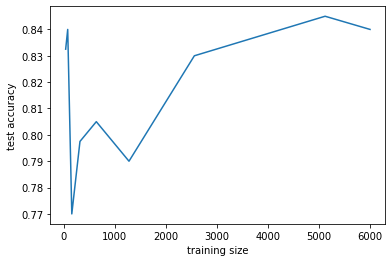

In [ ]:
# plot the test accuracy versus training size
import matplotlib.pyplot as plt
import pandas as pd
plt.plot(train_size, acc)
plt.xlabel('training size')
plt.ylabel('test accuracy')

As shown in the plot, the test accuracy was about 83% with 40 images, which then decreased and increased back to around 85%.

####__Potential reasons to accuracy drop__

Theoretically, the test accuracy should increase with the training size. However, for my model, the accuracy first dropped and then increased. There might be a few reasons leading to this:
1. The early stopping patience of 10 is too small. 
2. The total epoch available is only 40, which can be too low for some training sizes. For example, with training sizes of 160, 320 and 6000, 40 epochs were reached before early stopping was activated. This does correspond to the drops on the test accuracy curve. Hence, further increasing the epoch may help resolve this issue.

Besides, the accuracy is pretty high with only 40 training images, indicating that with proper model setup, it is possible for neural networks to generate relatively good prediction results.

#### __Loss difference between training and validation set__

Moreover, during the training process, the training loss was found to be much higher than the validation loss. This is partially due to the usage of 50% dropout, where 50% of the nodes were not connected when calculating training accuracy, but fully connected when calculating the validation accuracy. Usage of batch normalization may also contribute to the difference. During the training process, the batch normalization uses mean and variances of the given input batch, which might be changing. However, under evaluation mode, it uses the running mean and variance, both of which reflect properties of the whole training set much better.